### Applying dgl implementation of graphsage on NPP symmetric network

In [1]:
import numpy as np
from dgl.graph import DGLGraph
import torch
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl
import random
from dgl import DGLGraph
import seaborn as sns
from cell import plot_utils, utils
from dgl.nn.pytorch import conv as dgl_conv
from dgl.data.utils import download, extract_archive, get_download_dir, _get_dgl_url
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.manifold import TSNE
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

class NPPDataset(object):
    def __init__(self, path, self_loop=False):
        self_loop_str = ""
        if self_loop:
            self_loop_str = "_self_loop"
        
        with open(path, 'rb') as handle:
            npp_data = pickle.load(handle)
        # graph
        adj = npp_data['npp']
        self.graph = DGLGraph(adj, readonly=True)
        self.features = npp_data["feature"]
        self.labels = npp_data["label"]
        self.num_labels = 93
        
        # tarin/val/test indices
#         node_ids = np.array([i for i in range(93)])
#         node_types = np.array([1 for i in range(93)])
#         self.train_mask = (node_types == 1)
#         self.val_mask = (node_types == 1)
#         self.test_mask = (node_types == 1)

        print('Finished data loading.')
        print('  NumNodes: {}'.format(self.graph.number_of_nodes()))
        print('  NumEdges: {}'.format(self.graph.number_of_edges()))
        print('  NumFeats: {}'.format(self.features.shape[1]))
        print('  NumClasses: {}'.format(self.num_labels))

    def __getitem__(self, idx):
        assert idx == 0, "NPP Dataset only has one graph"
        g = self.graph
        g.ndata['feat'] = self.features
        g.ndata['label'] = self.labels
        return g
    
    def __len__(self):
        return 1


Using backend: pytorch


In [2]:
class GraphSAGEModel(nn.Module):
    def __init__(self,
                 in_feats,
                 n_hidden,
                 out_dim,
                 n_layers,
                 activation,
                 dropout,
                 aggregator_type):
        super(GraphSAGEModel, self).__init__()
        self.layers = nn.ModuleList()

        # input layer
        self.layers.append(dgl_conv.SAGEConv(in_feats, n_hidden, aggregator_type,
                                         feat_drop=dropout, activation=activation))
        # hidden layers
        for i in range(n_layers - 1):
            self.layers.append(dgl_conv.SAGEConv(n_hidden, n_hidden, aggregator_type,
                                             feat_drop=dropout, activation=activation))
        # output layer
        self.layers.append(dgl_conv.SAGEConv(n_hidden, out_dim, aggregator_type,
                                         feat_drop=dropout, activation=None))

    def forward(self, g, features):
        h = features
        for layer in self.layers:
            h = layer(g, h)
        return h

In [3]:
cldf = utils.read_visp_npp_cldf()

Reading cldf from: //Users/fahimehb/Documents/NPP_GNN_project/dat/cl_df_VISp_annotation.csv


In [4]:
# NCE loss
def NCE_loss(pos_score, neg_score, neg_sample_size):
    pos_score = F.logsigmoid(pos_score)
    neg_score = F.logsigmoid(-neg_score).reshape(-1, neg_sample_size)
    return -pos_score - torch.sum(neg_score, dim=1)


class LinkPrediction(nn.Module):
    def __init__(self, gconv_model):
        super(LinkPrediction, self).__init__()
        self.gconv_model = gconv_model

    def forward(self, g, features, neg_sample_size):
        emb = self.gconv_model(g, features)
        pos_g, neg_g = edge_sampler(g, neg_sample_size, return_false_neg=False)
        pos_score = score_func(pos_g, emb)
        neg_score = score_func(neg_g, emb)
        return torch.mean(NCE_loss(pos_score, neg_score, neg_sample_size))


In [86]:
p, n = edge_sampler(g, 1, return_false_neg=False)
emb = get_emb(gconv, g, features)
print(score_func(p, emb))
print(score_func(n, emb))

tensor([ 0.9754,  1.7147,  0.2313,  0.5362,  1.9104,  0.7604,  0.9193,  0.6722,
         0.2372,  0.5002, -1.4589,  0.7752,  0.7234,  0.6663,  0.8557,  1.2303,
         1.1761, -0.0851,  0.1605,  0.7023,  0.9827, -0.8211,  1.0653,  0.5891,
         0.7843,  0.7235,  0.7955,  0.5328, -0.3215,  0.6116,  0.7406,  1.1701,
         1.0730,  1.1145,  1.1388,  0.6369,  0.4592,  0.3341,  0.8648,  1.6647,
        -0.0780,  1.1716,  0.6142,  0.6470,  1.8047,  0.8396,  0.7439,  1.2323,
         0.8134,  0.6787, -0.3441,  0.5202,  1.1208,  1.6591,  1.7226])
tensor([ 0.3559,  0.5157, -0.5055, -0.7256, -0.3842,  0.1762, -0.3484,  0.6135,
         0.3466,  0.8486, -1.7131,  0.1456, -0.5131,  0.3715, -0.0499,  1.6232,
         0.6962,  1.4509,  0.3230, -0.3568, -0.0491, -1.0518, -1.1594,  0.7546,
        -0.6142, -1.0028,  0.0573, -0.2309,  0.0501, -1.1542,  0.3185, -0.6317,
        -0.0572,  0.9435, -0.0089, -0.5405,  0.5659, -0.7092,  2.0413,  0.6022,
        -0.0519, -0.3998, -0.0333,  0.7531,  0.0

In [5]:
def prepare_input(path):
    data = NPPDataset(path)
    features = torch.FloatTensor(data.features)
    in_feats = features.shape[1]
    labels = torch.LongTensor(data.labels)
    n_classes = data.num_labels

    g = DGLGraph(data.graph)
    g.readonly()
    return data, features, in_feats, labels, n_classes, g

In [6]:
def edge_sampler(g, neg_sample_size, edges=None, return_false_neg=True):
    sampler = dgl.contrib.sampling.EdgeSampler(g, batch_size=int(g.number_of_edges()/10),
                                               seed_edges=edges,
                                               neg_sample_size=neg_sample_size,
                                               negative_mode='tail',
                                               shuffle=True,
                                               return_false_neg=return_false_neg)
    sampler = iter(sampler)
    return next(sampler)

In [7]:
def score_func(g, emb, parent_graph=False):
    src_nid, dst_nid = g.all_edges(order='eid')
    # Get the node Ids in the parent graph.
    if not parent_graph:
        src_nid = g.parent_nid[src_nid]
        dst_nid = g.parent_nid[dst_nid]
    # Read the node embeddings of the source nodes and destination nodes.
    pos_heads = emb[src_nid]
    pos_tails = emb[dst_nid]
    return torch.sum(pos_heads * pos_tails, dim=1)

In [8]:
def LPEvaluate(gconv_model, g, features, eval_eids, neg_sample_size):
    gconv_model.eval()
    with torch.no_grad():
        emb = gconv_model(g, features)
        
        pos_g, neg_g = edge_sampler(g, neg_sample_size, eval_eids, return_false_neg=True)
        pos_score = score_func(pos_g, emb)
        neg_score = score_func(neg_g, emb).reshape(-1, neg_sample_size)
        filter_bias = neg_g.edata['false_neg'].reshape(-1, neg_sample_size)

        pos_score = F.logsigmoid(pos_score)
        neg_score = F.logsigmoid(neg_score)
        neg_score -= filter_bias.float()
        pos_score = pos_score.unsqueeze(1)
        rankings = torch.sum(neg_score >= (pos_score), dim=1) + 1
        return np.mean(1.0/rankings.cpu().numpy())

In [13]:
def prepare_train_test_valid(g):
    eids = np.random.permutation(g.number_of_edges())
    train_eids = eids[:int(len(eids) * 0.8)]
    valid_eids = eids[int(len(eids) * 0.8):int(len(eids) * 0.9)]
    test_eids = eids[int(len(eids) * 0.9):]
    train_g = g.edge_subgraph(train_eids, preserve_nodes=True)
    return train_eids, valid_eids, test_eids, train_g

In [14]:
def plot_pca_importance(h, n_hidden):
    vectors = h.detach().numpy()
    pca = PCA(n_components=n_hidden)
    pca.fit(vectors)
    pca_data = pca.transform(vectors)
    
    per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
    labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
    
    plt.figure(figsize=(20,5))
    plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label= labels)
    plt.xticks(rotation = 90)
    plt.show()

In [15]:
def plot_emb(h, n_hidden, data, cldf, plot_dim, plot_size=(8,8)):
    
    emb = h.detach().numpy()
    emb = pd.DataFrame(emb, columns=["Z"+str(i) for i in range(n_hidden)])
    emb['cluster_id'] = data.labels.astype('str')
    emb = emb.merge(cldf, on = "cluster_id")
    plot_utils.plot_embedding(emb, plot_dim= plot_dim, plot_size=plot_size)

    plt.show()

In [16]:
def plot_tsne(h, data, cldf,):
    
    tsne = TSNE(n_components=2 , random_state=42)
    emb = tsne.fit_transform(h.detach().numpy())

    emb = pd.DataFrame(emb)
    emb['cluster_id'] = data.labels.astype('str')
    emb = emb.merge(cldf, on = "cluster_id")
    plt.scatter(emb[0], emb[1], c = emb['cluster_color'])

    plt.show()

In [17]:
def training(in_feats, features, n_hidden, n_layers, dropout, aggregator_type, lr, 
          weight_decay, g, n_epochs, neg_sample_size):
    
    #Sage model
    gconv_model = GraphSAGEModel(in_feats,
                                 n_hidden,
                                 n_hidden,
                                 n_layers,
                                 F.relu,
                                 dropout,
                                 aggregator_type)
    
    # Model for link prediction
    model = LinkPrediction(gconv_model)

    # use optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    train_eids, valid_eids, test_eids, train_g = prepare_train_test_valid(g)

    # initialize graph
    dur = []
    for epoch in range(n_epochs):
        model.train()
        loss = model(train_g, features, neg_sample_size)
        optimizer.zero_grad()
        loss.backward()
    
        optimizer.step()
        acc = LPEvaluate(gconv_model, g, features, valid_eids, neg_sample_size)
        #print("Epoch {:05d} | Loss {:.4f} | MRR {:.4f}".format(epoch, loss.item(), acc))

    print()
    # Let's save the trained node embeddings.
    acc = LPEvaluate(gconv_model, g, features, test_eids, neg_sample_size)
    print("Test MRR {:.4f}".format(acc))
    return gconv_model

In [18]:
def get_emb(gconv_model, g, features):
    gconv_model.eval()
    with torch.no_grad():
        emb = gconv_model(g, features)
    return emb

### Experiment with sparse realisitc adj and 52 npp genes as features and n_hidden=20

Finished data loading.
  NumNodes: 93
  NumEdges: 558
  NumFeats: 52
  NumClasses: 93

Test MRR 0.9091


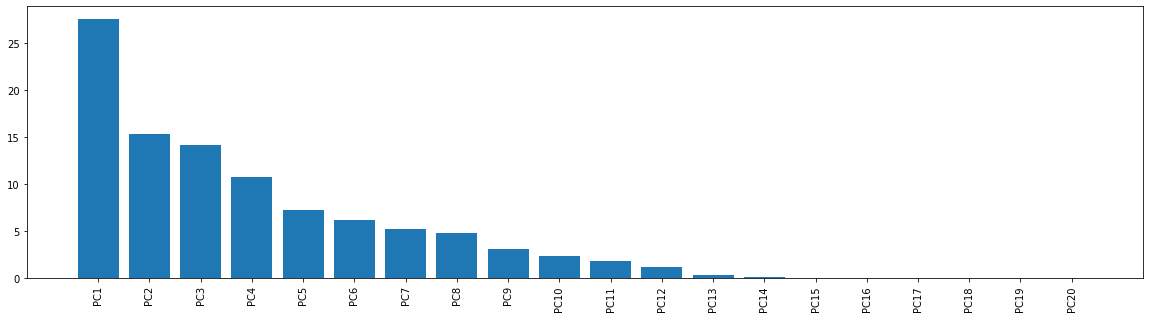

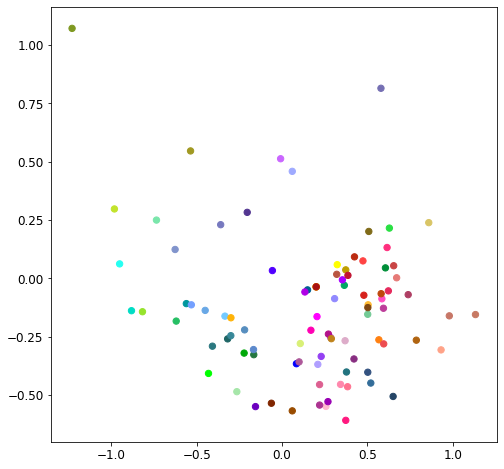

In [30]:
n_hidden = 20
n_layers = 1
dropout = 0
aggregator_type = 'gcn'

# Training hyperparameters
weight_decay = 5e-4
n_epochs = 10000
lr = 2e-3
neg_sample_size = 1

data, features, in_feats, labels, n_classes, g = prepare_input("/Users/fahimehb/Documents/NPP_GNN_project/dat/npp_sparse_realistic_adj_features_52.pkl")
# fig = plt.figure(figsize=(8,8))
# ax = sns.heatmap(data.graph.adjacency_matrix_scipy().todense())
# ax.tick_params(labelsize=8)
# ax.invert_yaxis()
gconv = training(in_feats, features, n_hidden, n_layers, dropout, aggregator_type, lr, weight_decay, g, n_epochs, neg_sample_size)
h = get_emb(gconv, g, features)
plot_pca_importance(h, n_hidden)
plot_emb(h, n_hidden, data, cldf, 2)

##### prediction accuracy is around ~85%

### the same thing with n_hidden=15


Test MRR 0.9000


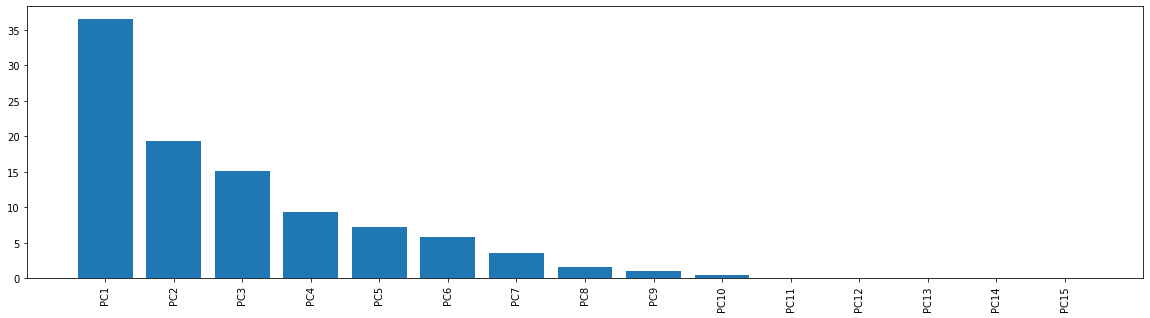

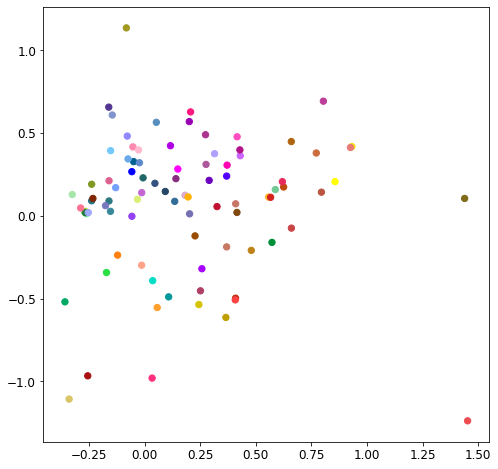

In [17]:
n_hidden = 15
n_epochs = 10000
gconv = training(in_feats, features, n_hidden, n_layers, dropout, aggregator_type, lr, weight_decay, g, n_epochs, neg_sample_size)
h = get_emb(gconv, g, features)
plot_pca_importance(h, n_hidden)
plot_emb(h, n_hidden, data, cldf, 2)

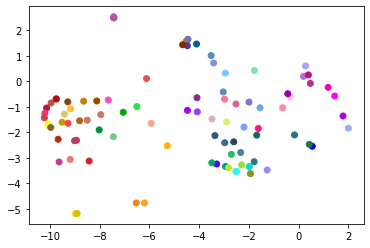

In [25]:
plot_tsne(h, data, cldf)

##### Prediction accuracy is ~ 87%

### The same thing with n_hidden = 5

Finished data loading.
  NumNodes: 93
  NumEdges: 558
  NumFeats: 52
  NumClasses: 93

Test MRR 0.8455


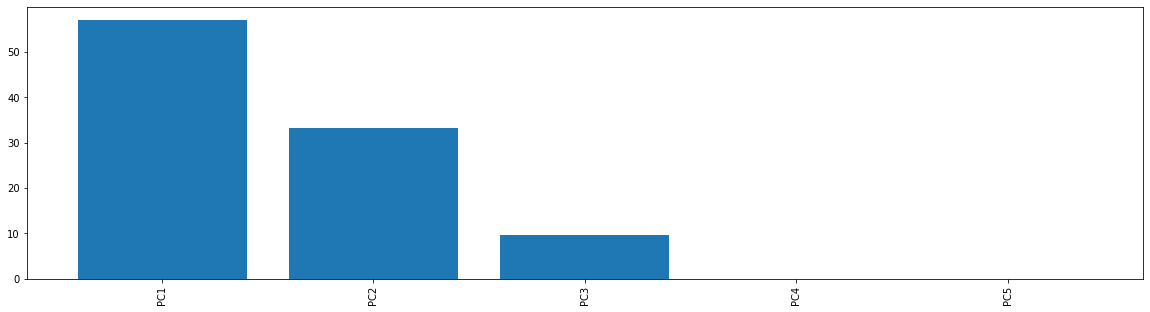

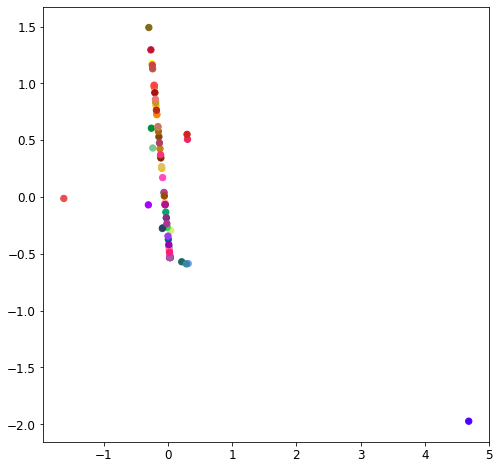

In [60]:
n_hidden = 5
n_layers = 1
dropout = 0
aggregator_type = 'gcn'

# Training hyperparameters
weight_decay = 5e-4
n_epochs = 10000
lr = 2e-3
neg_sample_size = 1

data, features, in_feats, labels, n_classes, g = prepare_input("/Users/fahimehb/Documents/NPP_GNN_project/dat/npp_sparse_realistic_adj_features_52.pkl")
gconv = training(in_feats, features, n_hidden, n_layers, dropout, aggregator_type, lr, weight_decay, g, n_epochs, neg_sample_size)
h = get_emb(gconv, g, features)
plot_pca_importance(h, n_hidden)
plot_emb(h, n_hidden, data, cldf, 2)

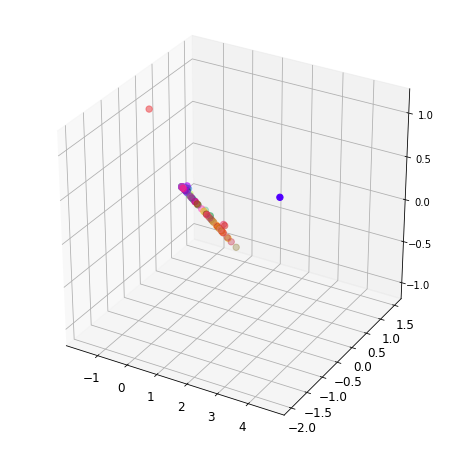

In [61]:
plot_emb(h, n_hidden, data, cldf, 3)

### Now if we use the dense (exact) adj metrix with 52 npp genes as features

Finished data loading.
  NumNodes: 93
  NumEdges: 8649
  NumFeats: 52
  NumClasses: 93

Test MRR 1.0000


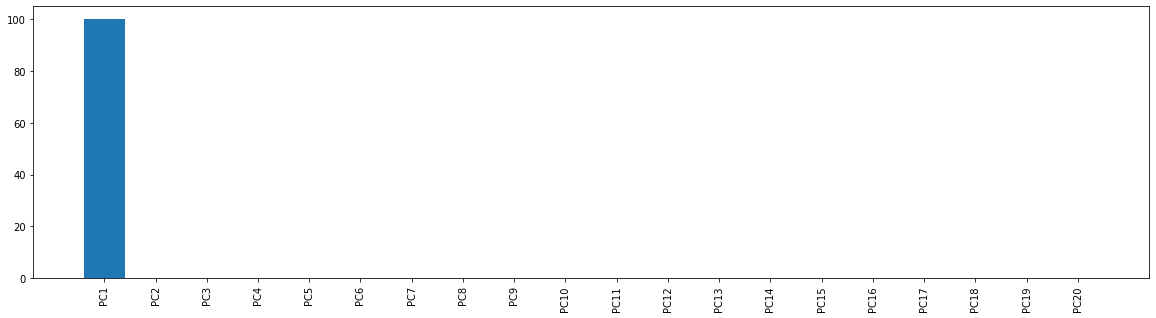

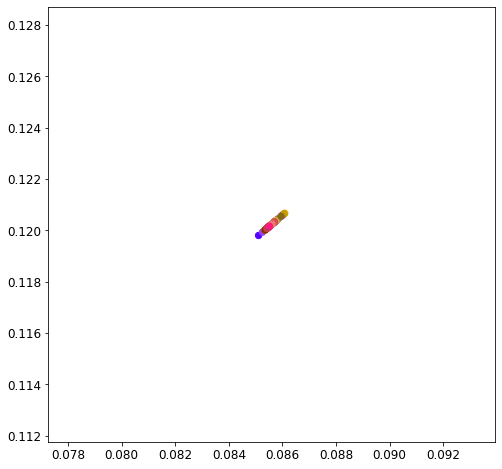

In [16]:
n_hidden = 20
n_layers = 1
dropout = 0
aggregator_type = 'gcn'

# Training hyperparameters
weight_decay = 5e-4
n_epochs = 100
lr = 2e-3
neg_sample_size = 1

data, features, in_feats, labels, n_classes, g = prepare_input("/Users/fahimehb/Documents/NPP_GNN_project/dat/npp_exact_adj_features_52.pkl")
gconv = training(in_feats, features, n_hidden, n_layers, dropout, aggregator_type, lr, weight_decay, g, n_epochs, neg_sample_size)
h = get_emb(gconv, g, features)
plot_pca_importance(h, n_hidden)
plot_emb(h, n_hidden, data, cldf, 2)

### The sparse realistic adj matrix with 4020 genes instead of 52 npp genes

Finished data loading.
  NumNodes: 93
  NumEdges: 558
  NumFeats: 4020
  NumClasses: 93

Test MRR 0.5455


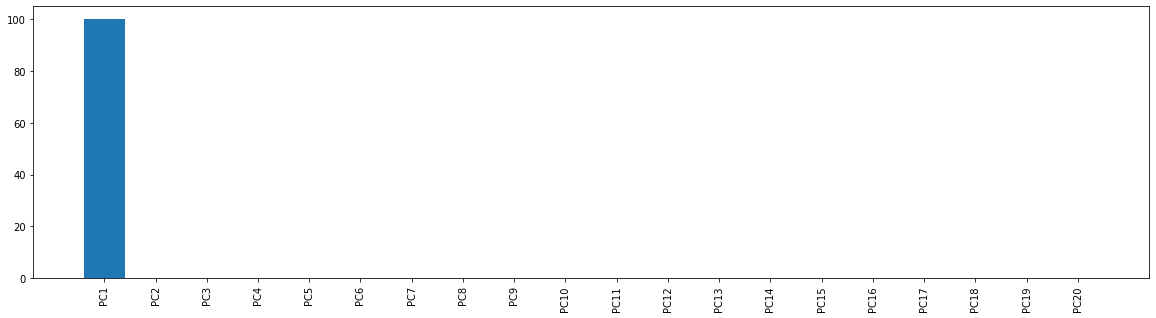

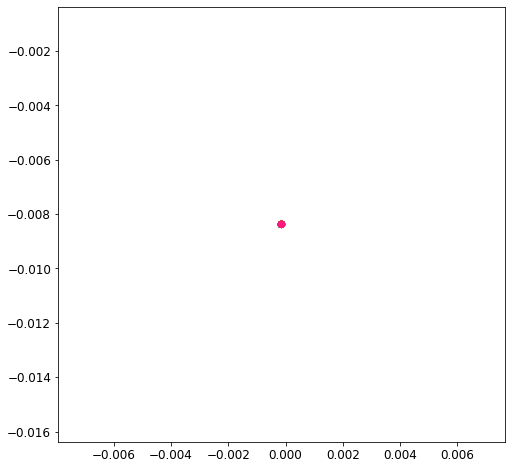

In [40]:
data, features, in_feats, labels, n_classes, g = prepare_input("/Users/fahimehb/Documents/NPP_GNN_project/dat/npp_sparse_realistic_adj_features_4020.pkl")
h = train(in_feats, features, n_hidden, n_layers, dropout, aggregator_type, lr, weight_decay, g, n_epochs, neg_sample_size)
plot_pca_importance(h, n_hidden)
plot_emb(h, n_hidden, data, cldf, 2)

### The same thing with dropout rate of 0.95

Finished data loading.
  NumNodes: 93
  NumEdges: 558
  NumFeats: 4020
  NumClasses: 93

Test MRR 0.5182


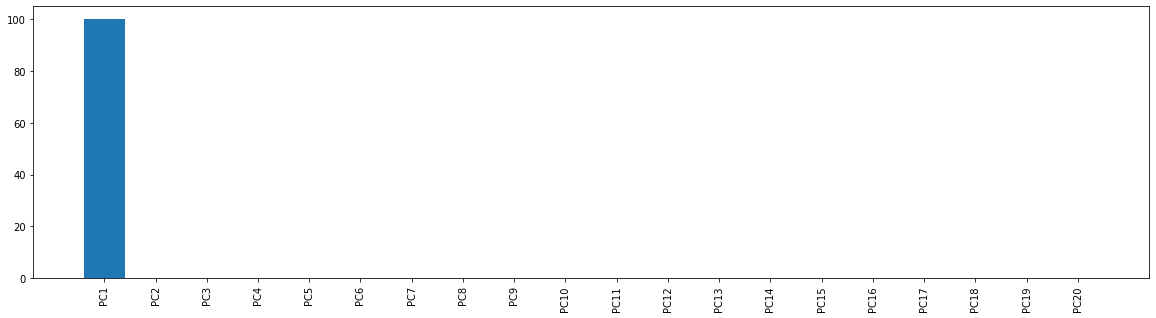

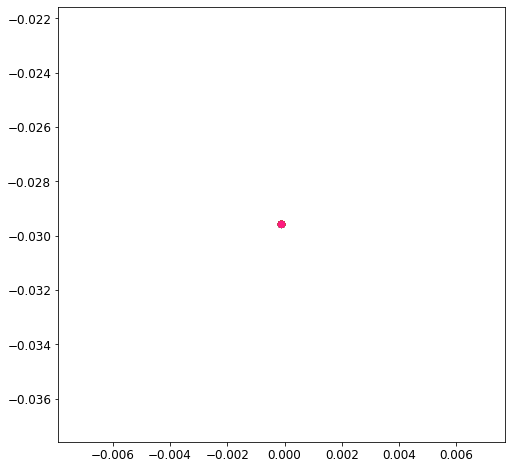

In [41]:
dropout = 0.95
data, features, in_feats, labels, n_classes, g = prepare_input("/Users/fahimehb/Documents/NPP_GNN_project/dat/npp_sparse_realistic_adj_features_4020.pkl")
h = train(in_feats, features, n_hidden, n_layers, dropout, aggregator_type, lr, weight_decay, g, n_epochs, neg_sample_size)
plot_pca_importance(h, n_hidden)
plot_emb(h, n_hidden, data, cldf, 2)

Therefore if we choose a sparse matrix together with few number of features and for not very small n_hidden, we can obtain a reasonable embedding.


### sparse adj matrix being used as feature

Finished data loading.
  NumNodes: 93
  NumEdges: 558
  NumFeats: 93
  NumClasses: 93

Test MRR 0.9091


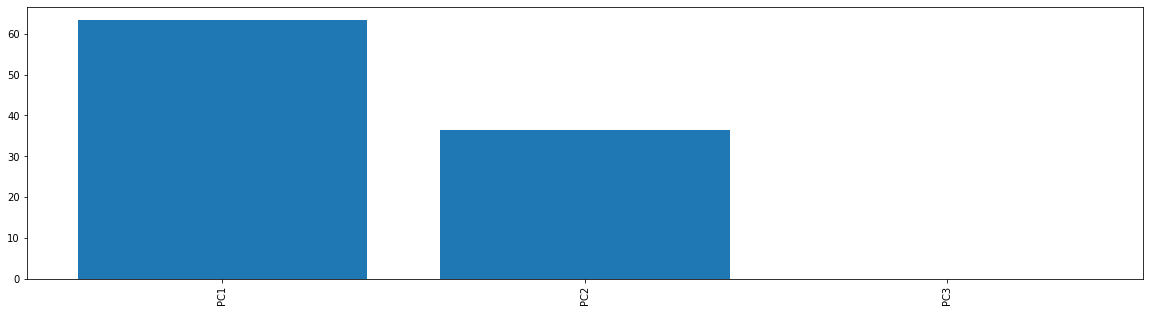

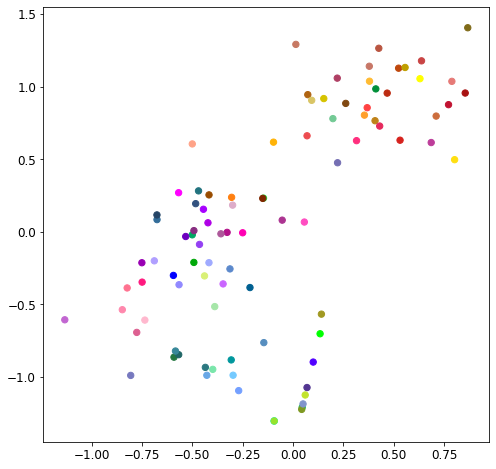

In [19]:
n_hidden = 3
n_layers = 1
dropout = 0
aggregator_type = 'gcn'

# Training hyperparameters
weight_decay = 5e-4
n_epochs = 10000
lr = 2e-3
neg_sample_size = 1

data, features, in_feats, labels, n_classes, g = prepare_input("/Users/fahimehb/Documents/NPP_GNN_project/dat/npp_sparse_realistic_adj_features_npp.pkl")
gconv = training(in_feats, features, n_hidden, n_layers, dropout, aggregator_type, lr, weight_decay, g, n_epochs, neg_sample_size)
h = get_emb(gconv, g, features)
plot_pca_importance(h, n_hidden)
plot_emb(h, n_hidden, data, cldf, 2)

Finished data loading.
  NumNodes: 93
  NumEdges: 558
  NumFeats: 93
  NumClasses: 93

Test MRR 0.8091


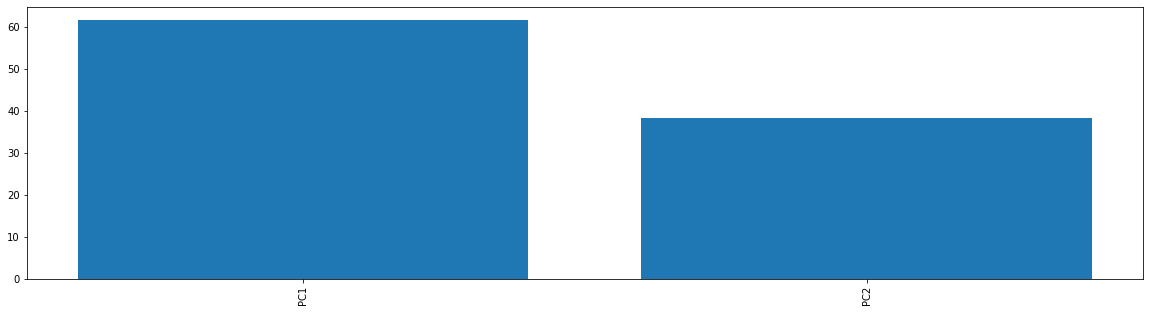

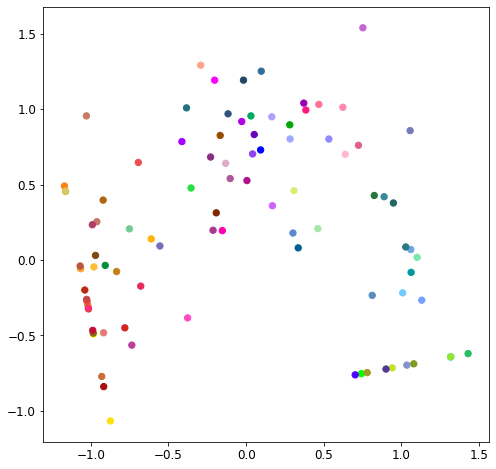

In [19]:
n_hidden = 2
n_layers = 1
dropout = 0
aggregator_type = 'gcn'

# Training hyperparameters
weight_decay = 5e-4
n_epochs = 10000
lr = 2e-3
neg_sample_size = 1

data, features, in_feats, labels, n_classes, g = prepare_input("/Users/fahimehb/Documents/NPP_GNN_project/dat/npp_sparse_realistic_adj_features_npp.pkl")
gconv = training(in_feats, features, n_hidden, n_layers, dropout, aggregator_type, lr, weight_decay, g, n_epochs, neg_sample_size)
h = get_emb(gconv, g, features)
plot_pca_importance(h, n_hidden)
plot_emb(h, n_hidden, data, cldf, 2)

Finished data loading.
  NumNodes: 93
  NumEdges: 558
  NumFeats: 93
  NumClasses: 93

Test MRR 0.8727


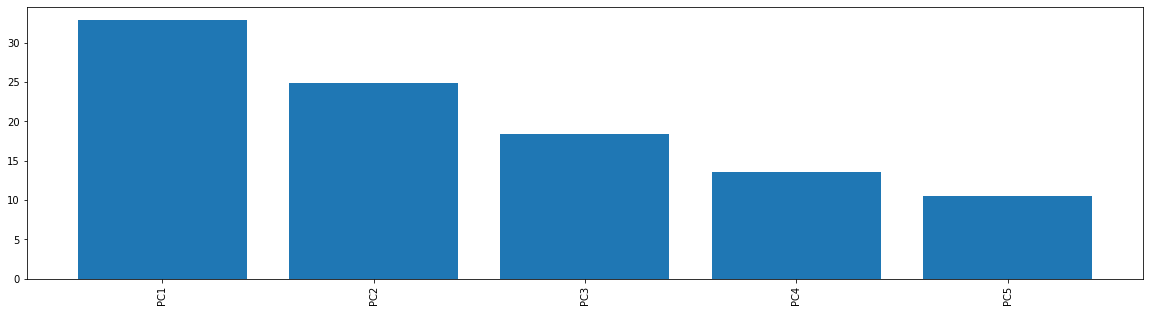

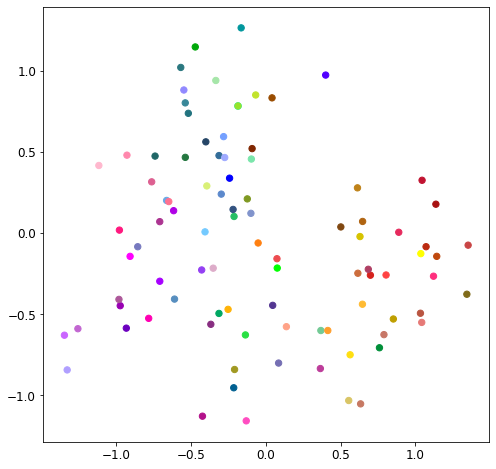

In [20]:
n_hidden = 5
n_layers = 1
dropout = 0
aggregator_type = 'gcn'

# Training hyperparameters
weight_decay = 5e-4
n_epochs = 10000
lr = 2e-3
neg_sample_size = 1

data, features, in_feats, labels, n_classes, g = prepare_input("/Users/fahimehb/Documents/NPP_GNN_project/dat/npp_sparse_realistic_adj_features_npp.pkl")
gconv = training(in_feats, features, n_hidden, n_layers, dropout, aggregator_type, lr, weight_decay, g, n_epochs, neg_sample_size)
h = get_emb(gconv, g, features)
plot_pca_importance(h, n_hidden)
plot_emb(h, n_hidden, data, cldf, 2)

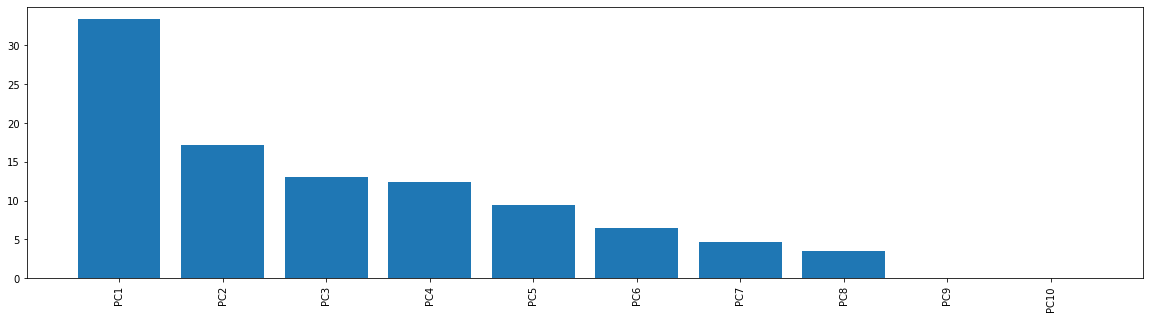

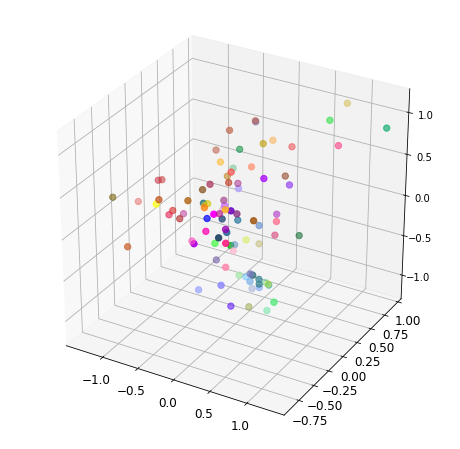

In [20]:
n_hidden = 10
n_layers = 1
dropout = 0
aggregator_type = 'gcn'

# Training hyperparameters
weight_decay = 5e-4
n_epochs = 10000
lr = 2e-3
neg_sample_size = 1

# data, features, in_feats, labels, n_classes, g = prepare_input("/Users/fahimehb/Documents/NPP_GNN_project/dat/npp_sparse_realistic_adj_features_npp.pkl")
# gconv = training(in_feats, features, n_hidden, n_layers, dropout, aggregator_type, lr, weight_decay, g, n_epochs, neg_sample_size)
# h = get_emb(gconv, g, features)
plot_pca_importance(h, n_hidden)
plot_emb(h, n_hidden, data, cldf, 3)

### Accuracy is 89%

## Sparse adj matrix and eye features

In [19]:
n_hidden = 10
n_layers = 1
dropout = 0
aggregator_type = 'gcn'

# Training hyperparameters
weight_decay = 5e-4
n_epochs = 10000
lr = 2e-3
neg_sample_size = 1

data, features, in_feats, labels, n_classes, g = prepare_input("/Users/fahimehb/Documents/NPP_GNN_project/dat/npp_sparse_realistic_adj_features_eye.pkl")
gconv = training(in_feats, features, n_hidden, n_layers, dropout, aggregator_type, lr, weight_decay, g, n_epochs, neg_sample_size)
h = get_emb(gconv, g, features)

Finished data loading.
  NumNodes: 93
  NumEdges: 558
  NumFeats: 93
  NumClasses: 93

Test MRR 0.9364


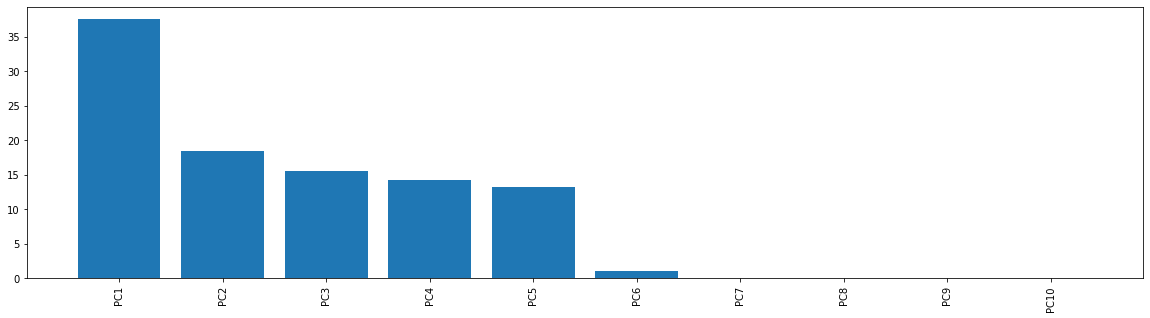

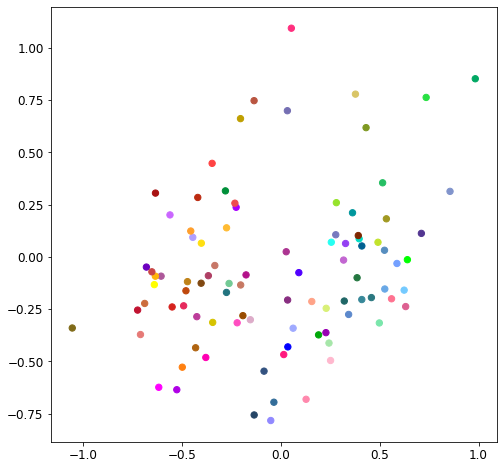

In [21]:
plot_pca_importance(h, n_hidden)
plot_emb(h, n_hidden, data, cldf, 2)

### Weighted Sparse adj matrix with adj as feature

In [47]:
n_hidden = 10
n_layers = 1
dropout = 0
aggregator_type = 'gcn'

# Training hyperparameters
weight_decay = 5e-4
n_epochs = 10000
lr = 2e-3
neg_sample_size = 1

data, features, in_feats, labels, n_classes, g = prepare_input("/Users/fahimehb/Documents/NPP_GNN_project/dat/npp_sparse_more_realistic_adj_features_adj.pkl")
gconv = training(in_feats, features, n_hidden, n_layers, dropout, aggregator_type, lr, weight_decay, g, n_epochs, neg_sample_size)
h = get_emb(gconv, g, features)

Finished data loading.
  NumNodes: 93
  NumEdges: 558
  NumFeats: 93
  NumClasses: 93

Test MRR 0.9364


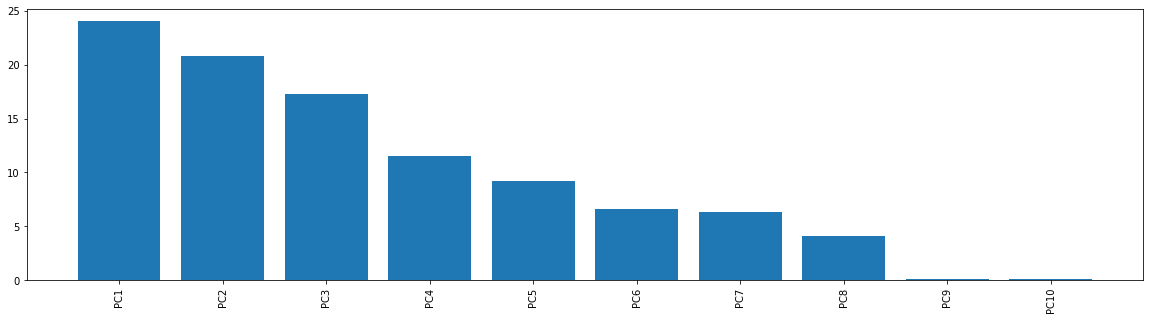

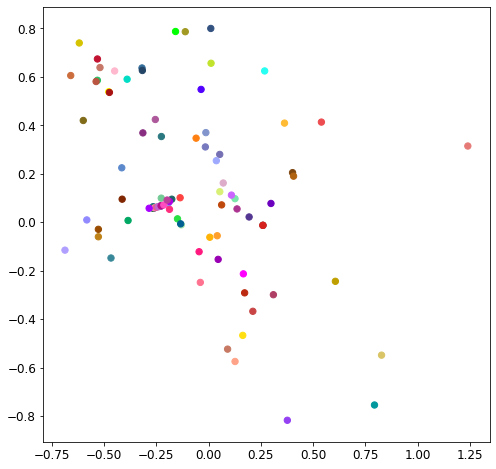

In [48]:
plot_pca_importance(h, n_hidden)
plot_emb(h, n_hidden, data, cldf, 2)

In [50]:
train_eids, valid_eids, test_eids, train_g  = prepare_train_test_valid(g)
pos_g, neg_g = edge_sampler(g, 1, test_eids, return_false_neg=True)
src_nid, dst_nid = pos_g.all_edges(order='eid')
src_nid = pos_g.parent_nid[src_nid]
dst_nid = pos_g.parent_nid[dst_nid]
print(g.has_edges_between(src_nid, dst_nid))
src_nid, dst_nid = neg_g.all_edges(order='eid')
src_nid = neg_g.parent_nid[src_nid]
dst_nid = neg_g.parent_nid[dst_nid]
print(g.has_edges_between(src_nid, dst_nid))

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0])


In [51]:
print(g.has_edge_between(1,0))
print(g.has_edge_between(0,1))

False
False


In [53]:
#g.edges()

In [44]:
g.out_edges(1)

(tensor([1, 1, 1, 1, 1, 1]), tensor([ 0, 27, 28, 29, 32, 34]))

In [72]:
test_eids

array([139, 108,  11, 474,  34, 178, 534, 184, 376, 101,  89, 462, 234,
       110, 431, 506, 429, 181,  61, 151, 209,  35, 227,  46, 456, 526,
        92, 519, 394, 147, 524,  50,  72,  25,  36, 373, 121, 193, 288,
       142, 447, 312, 267, 103, 223, 362, 497, 168, 293, 541, 345,  63,
       146, 533, 337, 152])

In [74]:
edge_sampler(g, 1, torch.tensor(test_eids))

(DGLGraph(num_nodes=54, num_edges=55,
          ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)}
          edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)}),
 DGLGraph(num_nodes=63, num_edges=55,
          ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)}
          edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64), 'false_neg': Scheme(shape=(), dtype=torch.int64)}))